# Kindle Book Recommender System

### Imports

In [1]:
#!pip install texthero
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD
from surprise.similarities import cosine, msd, pearson
import matplotlib as plt

In [2]:
df_rev = pd.read_csv('Data/scifan_rev.csv', index_col=0)

In [3]:
df_rev

,overall,reviewTime,reviewerID,asin,reviewText,summary
10,4,"05 17, 2011",AQZH7YTWQPOBE,B000FA64QO,Most of the New Jedi Order books focus on the ...,A Thrackan story
11,5,"01 27, 2014",A1ZT7WV0ZUA0OJ,B000FA64QO,I was hoping to find this one in book form. Th...,my e- collection
12,2,"04 15, 2013",A19T7R8I566N5Y,B000FA64QO,Books are supposed to be made of paper and ink...,I really hate e-books
13,3,"08 7, 2012",A22CW0ZHY3NJH8,B000FA64QO,"The events of ""Ylesia"" take place during ""Dest...",One huge chapter
156,5,"12 29, 2017",A2I8RAPMHOLR41,B000FBJBA4,"It started out good, slowed down and picked up...",Most Excellent
...,...,...,...,...,...,...
2222944,5,"02 1, 2017",A2AVG3WXEYCSFQ,B01HJBPUWA,I loved the blending of computer games with fa...,Exciting stories
2222946,4,"08 27, 2016",A8NRHVZY1EETX,B01HJBPUWA,"Overall, a fine group of uniquely different st...",Primarily pleasing tales of the fantastic
2222947,4,"08 9, 2016",A1X2L9GD8HJ3A3,B01HJBPUWA,Interesting story with more than a few surprises,Enjoyed it very much
2222948,5,"07 17, 2016",A1UXNP3BXWZPTO,B01HJBPUWA,Loved every story. Such a fantastic idea and ...,Great read


In [4]:
df_rev.isna().sum()

overall        0
reviewTime     0
reviewerID     0
asin           0
reviewText     7
summary       29
dtype: int64

In [5]:
df_rev.dropna(inplace=True)

In [6]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96318 entries, 10 to 2222950
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     96318 non-null  int64 
 1   reviewTime  96318 non-null  object
 2   reviewerID  96318 non-null  object
 3   asin        96318 non-null  object
 4   reviewText  96318 non-null  object
 5   summary     96318 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB


In [7]:
df_rev['reviewerID'].value_counts()

AYUTCGVSM1H7T     190
A10ED33F8VY4GU    117
A15IF7NAB1Y196    110
A2UMJFC1YME1R2     99
AX59HEWTONQ1M      98
                 ... 
A3CJQPNI9FD5TH      1
A1120M9ZK2U3FQ      1
A21OEPQLU5D37M      1
A27D9PEEP0N5U8      1
A13O4DKZ14RIRE      1
Name: reviewerID, Length: 31334, dtype: int64

In [8]:
df_rev5 = df_rev[df_rev['reviewerID'].map(df_rev['reviewerID'].value_counts()) > 4]

In [9]:
df_rev5['reviewerID'].value_counts()

AYUTCGVSM1H7T     190
A10ED33F8VY4GU    117
A15IF7NAB1Y196    110
A2UMJFC1YME1R2     99
AX59HEWTONQ1M      98
                 ... 
A4GNB2DIVOVGN       5
A155SWRGBW8TWG      5
A3BCKCRL7Q3DH8      5
A6R8RIIQT6TBJ       5
AA0IA2A58P6RZ       5
Name: reviewerID, Length: 5405, dtype: int64

In [10]:
df_rev5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50127 entries, 12 to 2222948
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     50127 non-null  int64 
 1   reviewTime  50127 non-null  object
 2   reviewerID  50127 non-null  object
 3   asin        50127 non-null  object
 4   reviewText  50127 non-null  object
 5   summary     50127 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


<AxesSubplot:>

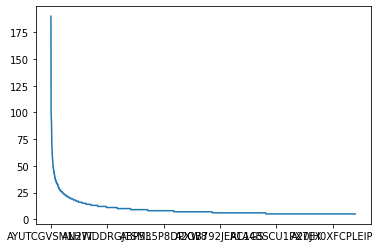

In [11]:
reviewers = df_rev5['reviewerID'].value_counts()
reviewers.plot()

In [12]:
popular = df_rev5.groupby(by = 'asin').count()
popular = popular.sort_values(by = 'overall', ascending=False)

In [13]:
popular

,overall,reviewTime,reviewerID,reviewText,summary
asin,,,,,
B00E9YL3HM,137,137,137,137,137
B00HGFP8W2,116,116,116,116,116
B00PXGD274,116,116,116,116,116
B004Z99U3K,100,100,100,100,100
B00L4VXSDA,97,97,97,97,97
...,...,...,...,...,...
B019991BAK,1,1,1,1,1
B0199UOI18,1,1,1,1,1
B00H5FW3C6,1,1,1,1,1


In [14]:
df_rev5.loc[df_rev5['asin'] == 'B00E9YL3HM']

,overall,reviewTime,reviewerID,asin,reviewText,summary
399470,5,"09 2, 2013",A3BFGP4QE7ATYV,B00E9YL3HM,Excellent. Endless action and adventure. The...,The Breakers Series: Books 1-3
399471,5,"08 23, 2013",A2EDWAYHHJCFL4,B00E9YL3HM,I was a little hesitant when I saw this three ...,Wow....
399474,4,"05 7, 2018",A26K1OD1IJYCM6,B00E9YL3HM,Aliens turn the world upside down by using a v...,Apocalypse Inspiration
399475,5,"04 27, 2018",A1ACUN6A2LYVMW,B00E9YL3HM,Such an entertaining and brilliant series and ...,Brilliant and very entertaining...
399476,5,"04 2, 2018",A2FJXPJ8BRF1GW,B00E9YL3HM,I love this authors writing style. The story s...,Well written
...,...,...,...,...,...,...
399812,4,"09 24, 2013",A101BX7DD7EUZ1,B00E9YL3HM,This is nearly a 9 book series considering eac...,a fun post apocalyptic series
399814,5,"09 14, 2013",A12K5Y2SEANYW0,B00E9YL3HM,A great start to an entertaining group of apoc...,Breakers 1- 3
399815,5,"09 12, 2013",AW2COSIBMO3PH,B00E9YL3HM,This really is a great series. Each book gives...,Excellent series
399817,5,"09 7, 2013",AACR3X19GRX1C,B00E9YL3HM,I am so glad I bought these books. They sounde...,Great!


In [15]:
df_most = df_rev5.loc[df_rev5['reviewerID'] == 'AYUTCGVSM1H7T']
df_most['overall'].value_counts()

5    176
4     13
3      1
Name: overall, dtype: int64

In [16]:
df_2most = df_rev5.loc[df_rev5['reviewerID'] == 'A10ED33F8VY4GU']
df_2most['overall'].value_counts()

4    60
5    37
3    19
2     1
Name: overall, dtype: int64

In [17]:
df_3most = df_rev5.loc[df_rev5['reviewerID'] == 'A15IF7NAB1Y196']
df_3most['overall'].value_counts()

5    93
4    13
3     2
2     2
Name: overall, dtype: int64

In [18]:
df_4most = df_rev5.loc[df_rev5['reviewerID'] == 'A2UMJFC1YME1R2']
df_4most['overall'].value_counts()

5    86
4    11
3     2
Name: overall, dtype: int64

In [19]:
df_5most = df_rev5.loc[df_rev5['reviewerID'] == 'AX59HEWTONQ1M']
df_5most['overall'].value_counts()

1    37
2    26
3    24
4    11
Name: overall, dtype: int64

In [20]:
df_rev5.head()

,overall,reviewTime,reviewerID,asin,reviewText,summary
12,2,"04 15, 2013",A19T7R8I566N5Y,B000FA64QO,Books are supposed to be made of paper and ink...,I really hate e-books
156,5,"12 29, 2017",A2I8RAPMHOLR41,B000FBJBA4,"It started out good, slowed down and picked up...",Most Excellent
158,3,"11 3, 2017",ADAYPZRLWYWH5,B000FBJBA4,Not as fast acting as I like. A bit too much i...,"OK, but not exciting"
161,5,"08 20, 2017",A2G4EEQIKOZF9R,B000FBJBA4,One of the most interesting books I have read ...,Great!
162,3,"08 6, 2017",A3IS3ZYST5QHMJ,B000FBJBA4,"I almost dumped this novel at the 4% mark, as ...",I don't give a rip about women's shoes


In [21]:
df_rev5['reviewText'].astype(str)

12         Books are supposed to be made of paper and ink...
156        It started out good, slowed down and picked up...
158        Not as fast acting as I like. A bit too much i...
161        One of the most interesting books I have read ...
162        I almost dumped this novel at the 4% mark, as ...
                                 ...                        
2222723    I consider this series to be quite different t...
2222724    If you like characters that aren't your typica...
2222944    I loved the blending of computer games with fa...
2222947     Interesting story with more than a few surprises
2222948    Loved every story.  Such a fantastic idea and ...
Name: reviewText, Length: 50127, dtype: object

In [32]:
df_books_rev = df_rev5.groupby(['asin'], as_index = False).agg({'reviewText': ' '.join})
df_books_rev.to_csv('Data/df_books_rev.csv')

In [33]:
df_reviewers_rev = df_rev5.groupby(['reviewerID'], as_index = False).agg({'reviewText': ' '.join})
df_reviewers_rev.to_csv('Data/df_reviewers_rev.csv')

In [34]:
df_books_sum = df_rev5.groupby(['asin'], as_index = False).agg({'summary': ' '.join})
df_books_sum.to_csv('Data/df_books_sum.csv')

In [35]:
df_reviewers_sum = df_rev5.groupby(['reviewerID'], as_index = False).agg({'summary': ' '.join})
df_reviewers_sum.to_csv('Data/df_reviewers_sum.csv')

In [26]:
df_books_sum.head()

,asin,summary
0,B000FA64QO,I really hate e-books
1,B000FBJBA4,"Most Excellent OK, but not exciting Great! I d..."
2,B000FC2S2Q,More than pleasantly Surprised! good book Far ...
3,B000W7KNE4,Wonderful debut series and good deal
4,B000ZH6VH4,Magical world meets computer generated reality...


In [27]:
df_reviewers_sum.head()

,reviewerID,summary
0,A0769183K7L2H54MJRG4,The defining moment of Fred Johnson's life and...
1,A0886097YX1F6V4PD6J7,it can not end there had to have a book ... Fi...
2,A1011UZJAELNPL,Is it bloody enough? A superbly written disast...
3,A101BX7DD7EUZ1,prequel that is a honey what a wonderful novel...
4,A101C9BMFZDH5A,tense and so well written I just couldn't put ...


In [28]:
user_ratings = df_rev5.pivot_table(index='reviewerID', columns = 'asin', values = 'overall')
user_ratings.head()

asin,B000FA64QO,B000FBJBA4,B000FC2S2Q,B000W7KNE4,B000ZH6VH4,B0014NKZM0,B0018GY5QU,B0018GYCRM,B001C9BIH2,B001CN47NA,...,B01HFR8BH4,B01HFSQMB0,B01HHA4KDS,B01HHFHD0U,B01HHJIUPS,B01HHJZ3EO,B01HHJZ628,B01HHVVZ62,B01HIOR0S0,B01HJBPUWA
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0769183K7L2H54MJRG4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0886097YX1F6V4PD6J7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1011UZJAELNPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101BX7DD7EUZ1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A101C9BMFZDH5A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#details = list(df_meta['details'])

In [30]:
#details